$$\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}$$

# CS236781:   Deep Learning
# Tutorial 2: Multilayer Perceptron

## Introduction

In this tutorial, we will cover:

* Linear (fully connected) layers
* Activation functions
* 2-Layer MLP implementation from scratch (self study)
* N-layer MLP with PyTorch's `autograd` and `optim` modules

In [2]:
# Setup
%matplotlib inline
import os
import numpy as np
import sklearn
import torch
import matplotlib.pyplot as plt
from typing import Sequence

In [3]:
plt.rcParams['font.size'] = 20

## Reminder: Perceptrons and linear models

The following hypothesis class
$$
\mathcal{H} =
\left\{ h: \mathcal{X}\rightarrow\mathcal{Y}
~\vert~
h(\vec{x}) = \varphi(\vectr{w}\vec{x}+b); \vec{w}\in\set{R}^D,~b\in\set{R}\right\}
$$
where $\varphi(\cdot)$ is some nonlinear function, is composed of functions representing the **perceptron** model.


<img src="imgs/perceptron.png" width=400 /> 

Last tutorial: we trained a **logistic regression** model by using
$$\varphi(\vec{z})=\sigma(\vec{z})=\frac{1}{1+\exp(-\vec{z})}\in[0,1].$$

**Limitation**: logistic regression is still a linear classifier. In what sense is it linear though?

$$\hat{y} = \sigma(\vectr{w}\vec{x}+b)$$

**Linear** in the sense that output depends only on a linear combination of weights and inputs.

Decision boundaries are therefore straight lines:

<center><img src="imgs/perceptron_db.png" width="600"/></center>

If we define $y(\vec{x})=\vectr{w}\vec{x}+b$, then the **decision surface** of the classifier is $y(\vec{x})=\text{const}$ (usually zero). Note that $b=w_0$ in the diagram below.

<center><img src="imgs/linear_discriminant.png" width="700"/></center>

1. For any $\vec{x_1}, \vec{x_2}$ on the decision boundary, $\vectr{w}(\vec{x_1}-\vec{x_2})=0$ $\Rightarrow \vec{w}$ orthogonal to every vector in the surface.
1. For any $\vec{x_1}$ on the decision boundary, $\vectr{w}\vec{x_1}=-b$.  
Since $\frac{\vectr{w}}{\norm{\vec{w}}}\vec{x_1}$ is the length of the projection of $\vec{x_1}$ onto $\vec{w}$, then the distance of the boundary from origin is given by
$\frac{-b}{\norm{\vec{w}}}$.
1. For any point $\vec{x}$, $\frac{y(\vec{x})}{\norm{\vec{w}}}$ is the **signed perpendicular distance** from the decision boundary.

What if our data is not linearly separable? Can we still use e.g. logistic regression?

<center><img src="imgs/nonlinear_datasets.png" width="1200"/></center>

What if we first apply a **fixed** non-linear transformation to the data?

For some $\psi: \set{R}^d \rightarrow \set{R}^D$, what does the following classifier do?

$$\hat{y} = \varphi(\vectr{w}\psi(\vec{x})+b).$$

We still get a linear decision boundary, but relative to the new features $\psi(\vec{x})\in\set{R}^D$.
Projecting this boundary back to $\set{R}^d$, we can get nonlinear decision boundaries with respect to $\vec{x}\in\set{R}^d$.

But how can we choose a nonlinear transformation?  
Traditional ML: Craft it painstakingly based on domain-knowledge.

But what if we want to **learn** it?

## Multilayer Perceptron (MLP)

### Model

<center><img src="imgs/mlp.png" width=1000 /></center>

Composed of $L$ **layers**, each layer $l$ with $n_l$ **perceptron** ("neuron") units.

Each layer $l$ operates on the output of the previous layer ($\vec{y}_{l-1}$) and calculates:

$$
\vec{y}_l = \varphi\left( \mat{W}_l \vec{y}_{l-1} + \vec{b}_l \right),~
\mat{W}_l\in\set{R}^{n_{l}\times n_{l-1}},~ \vec{b}_l\in\set{R}^{n_l},~ l \in \{1,2,\dots,L\}.
$$

- Note that both input and output are **vectors**. We can think of the above equation as describing a layer of **multiple perceptrons**.
- We'll henceforth refer to such layers as **fully-connected** or FC layers.
- The first layer accepts the input of the model, i.e. $\vec{y}_0=\vec{x}\in\set{R}^d$.
- The last layer, $L$, is the output layer, so $y_L$ is the output of the model.
- The layers $1, 2, \dots, L-1$ are called hidden layers.

How powerful is an MLP model? I.e. which functions can it approximate?

**Universal approximator theorem**

Given enough parameters, an MLP with $L>1$ and any non-linear activation function, can approximate any continuous function up to any specified precision (Cybenko, 1989).

The MLP is therefore a **potent hypothesis class** (recall approximation error).

See [here](http://neuralnetworksanddeeplearning.com/chap4.html) for an intuitive explanation of the UAT.

Given an input sample $\vec{x}^i$, the computed function of an $L$-layer MLP is:
$$
\vec{y}_L^i= \varphi \left(
\mat{W}_L \varphi \left( \cdots
\varphi \left( \mat{W}_1 \vec{x}^i + \vec{b}_1 \right)
\cdots \right)
+ \vec{b}_L \right)
$$

This expression is fully differentiable w.r.t. parameters using the Chain Rule.

And notice that $\vec{y}_L^i = \varphi(\mat{W}_L \vec{y}_{L-1}^i + \vec{b}_L)$ is just the linear model we started with.

So, intuitively, we can think of $\vec{y}_{L-1}$ as **learned** non-linear features of the input! In other words, $\vec{y}_{L-1} = \psi_{\vec{\Theta}}(\vec{x})$.

Since an MLP it has a non-linear dependency on it's inputs, through a learned transformation, non-linear decision boundaries are possible.

For example, an MLP with 1, 2 and 4 hidden layers, 3 neurons each:
    
<center><img src="imgs/overfit_1-2-4HL_3N.jpg" width="1100" alt="overfit1"></center>

Notice the input space has two features while the output space has three.

### Activation functions 

An **activation function** is the non-linear elementwise function $\varphi(\cdot)$ which operates on the affine part of the perceptron model.

Why do we even need non-linearities in the first place? Isn't the depth enough?

Without them, the MLP model would be equivalent to a single affine transform.

Common choices for the activation functions are:

- The logistic function (sigmoid)
    $$ \varphi(t) = \sigma(t) = \frac{1}{1+e^{-t}} \in  [0,1] $$
- The hyperbolic tangent (a shifted and scaled sigmoid)
    $$ \varphi(t) = \mathrm{tanh}(t) = \frac{e^t - e^{-t}}{e^t +e^{-t}} \in [-1,1]$$

- ReLU, rectified linear unit
    $$ \varphi(t) = \max\{t,0\} $$
Note that ReLU is not strictly differentiable. However, sub-gradients exist. We will define its gradient as:
    $$ \pderiv{\varphi}{t} = \begin{cases} 1, & t\geq0 \\ 0, & t<0 \end{cases} $$

In [4]:
# Plot some activation functions and their gradients

# Activation functions
relu = lambda x: np.maximum(0, x)
sigmoid = lambda x: 1 / (1 + np.exp(-x))
tanh = lambda x: (np.exp(x)-np.exp(-x)) / (np.exp(x)+np.exp(-x))

# Their gradients
g_relu = lambda x: np.array(relu(x) > 0, dtype=np.float)
g_sigmoid = lambda x: sigmoid(x) * (1-sigmoid(x))
g_tanh = lambda x: (1 - tanh(x) ** 2)

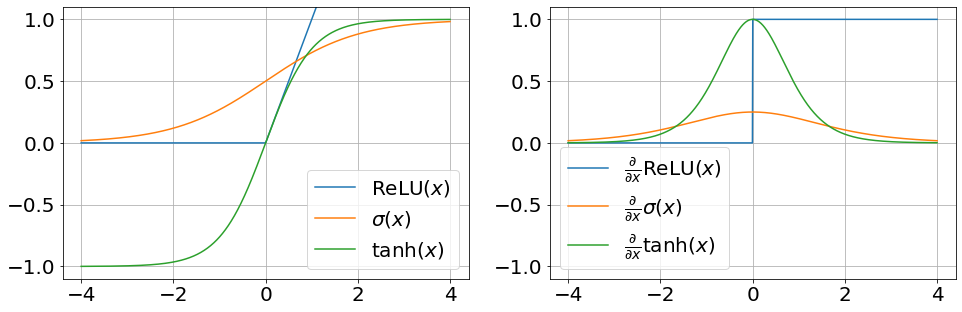

In [5]:
x = np.linspace(-4, 4, num=1024)
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
axes[0].plot(x, relu(x), x, sigmoid(x), x, tanh(x))
axes[1].plot(x, g_relu(x), x, g_sigmoid(x), x, g_tanh(x))
legend_entries = (r'\mathrm{ReLU}(x)', r'\sigma(x)', r'\mathrm{tanh}(x)')
for ax, legend_prefix in zip(axes, ('', r'\frac{\partial}{\partial x}')):
    ax.grid(True)
    ax.legend(tuple(f'${legend_prefix}{legend_entry}$' for legend_entry in legend_entries))
    ax.set_ylim((-1.1,1.1))

Some reasons people cite for using ReLU are:

- Does not suffer from vanishing gradient when $x$ is far from zero (though gradient can still be zero).

- Much faster to compute than sigmoid and tanh.

- Promotes sparse weight vectors: "dead neurons" arguably cause sparsity in the next layer.

### Visualization of hand-crafted features vs. MLP

Visualization of the effect of features and MLP layers: http://playground.tensorflow.org/

Try to explain what you see for the circles dataset with:
- No hidden layers
- One hidden layer, two neurons
- One hiddlen layer, three neurons

## Part 1: Two-layer MLP from scratch

Let's solve a simple **regression** problem with a 2-layer MLP (one hidden layer, one output layer).

We're trying to learn a continuous and perhaps non-deterministic function $y=f(\vec{x})$.

- Domain: $\vec{x}^i \in \set{R}^{D_{\text{in}}}$

- Target: $y^i \in \set{R}^{D_{\text{out}}}$

- Model: $\hat{y} =\mat{W}_2~ \varphi(\mat{W}_1 \vec{x}+ \vec{b}_1) + \vec{b}_2$<br>
  i.e. a 2-layer MLP, where:
    - $\vec{x}\in\set{R}^{D_{\text{in}}}$ sample (feature vector)
    - $\mat{W}_1\in\set{R}^{H\times D_{\text{in}}},\ \vec{b}_1\in\set{R}^{H}$
    - $\mat{W}_2\in\set{R}^{D_{\text{out}}\times H},\ \vec{b}_2\in\set{R}^{D_{\text{out}}}$
    - $\varphi(\cdot) = \mathrm{ReLU}(\cdot) = \max\{\cdot,0\}$
    - $H$ is the hidden dimension
    - We'll set $D_{\text{out}}=1$ so output is a scalar
   

 
- MSE loss with L2 regularization:
    $$
    \begin{align}
    \ell(\vec{y},\vec{\hat y}) &= \frac{1}{2}\norm{\vec{\hat y} - \vec{y}}^2 \\
    L_{\mathcal{S}} &= \frac{1}{N}\sum_{i=1}^{N}\ell(\vec{y},\vec{\hat y}) + \frac{\lambda}{2}\left(\norm{\mat{W}_1}_F^2 + \norm{\mat{W}_2}_F^2 \right)
    \end{align}
    $$
- Optimization scheme: Vanilla SGD

### Computing the loss gradients with backpropagation

Let's write our model as 
$$
\hat{y} =\mat{W}_2~ \underbrace{\mathrm{relu}(\overbrace{\mat{W}_1 \vec{x}+ \vec{b}_1}^{\vec{z}})}_{\vec{a}} + \vec{b}_2,
$$

and manually derive the gradient of the point-wise loss $\ell(\vec{y},\vec{\hat y})$ using the **chain rule**.
Remember that to use SGD, we need the gradient of the loss w.r.t. our parameter tensors.

$$
\begin{align}
&\pderiv{\ell}{\vec{\hat y}}=2\cdot\frac{1}{2}(\vec{\hat y}-\vec{y}) = (\vec{\hat y}-\vec{y})\\
(\ast)~~&\pderiv{\ell}{\mat{W}_2}= \pderiv{\ell}{\vec{\hat y}}\pderiv{\vec{\hat y}}{\mat{W}_2}
=(\vec{\hat y}-\vec{y})\vectr{a}
\end{align}
$$

How do we continue into the nonlinearity? Recall that we defined

$$ \pderiv{\mathrm{relu}(x)}{x} = \begin{cases} 1, & x\geq0 \\ 0, & x<0 \end{cases} $$

and that we apply the non-linearity elementwise on input tensors.

Also remember that the gradient of a vector w.r.t. another vector is the Jacobian, a matrix of mixed derivatives:
$\pderiv{a_i}{z_j}$.

We have $\vec{a}=\mathrm{relu}(\vec{z})$. Thus,

$$
\pderiv{\vec{a}}{\vec{z}}=\mathrm{diag}(\mathbb{1}[\vec{z}>0]).
$$


And so,
$$
\begin{align}
&\pderiv{\ell}{\vec{a}}=\pderiv{\vec{\hat y}}{\vec{a}}\pderiv{\ell}{\vec{\hat y}}
=\mattr{W}_2(\vec{\hat y}-\vec{y})\\
&\pderiv{\ell}{\vec{z}}=\pderiv{\vec{a}}{\vec{z}}\pderiv{\ell}{\vec{a}}
=\mathrm{diag}(\mathbb{1}[\vec{z}>0])\mattr{W}_2(\vec{\hat y}-\vec{y})\\
(\ast)~~&\pderiv{\ell}{\mat{W}_1}=\pderiv{\ell}{\vec{z}}\pderiv{\vec{z}}{\mat{W}_1}
=\mathrm{diag}(\mathbb{1}[\vec{z}>0])\mattr{W}_2(\vec{\hat y}-\vec{y})\vectr{x}\\
\end{align}
$$

For the biases, we can easily see that:
$$
\begin{align}
(\ast)~~&\pderiv{\ell}{\vec{b}_2}=\pderiv{\vec{\hat y}}{\vec{b}_2}\pderiv{\ell}{\vec{\hat y}}
=I_{D_{\text{out}}} \pderiv{\ell}{\vec{\hat y}} \\
(\ast)~~&\pderiv{\ell}{\vec{b}_1}=\pderiv{\vec{z}}{\vec{b}_1}\pderiv{\ell}{\vec{z}}
=I_{H}\pderiv{\ell}{\vec{z}}\\
\end{align}
$$

The final gradients for weight update, including regularization will be

$$
\nabla_{\mat{W}_j}L_{\mathcal{S}}=\frac{1}{N}\sum_{i=1}^{N} \pderiv{\ell_i}{\mat{W}_j} + \lambda\mat{W}_j, \ j=1,2.
$$

Let's implement it from scratch using just `numpy`.

In [6]:
# A simple MLP with one hidden layer

# N: batch size
# D_in: number of features
N, D_in =  64, 10
# H: hidden-layer
# D_out: output dimension
H, D_out =  100, 1

# Random input data
X = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

# Model weights and biases
wstd = 0.01
W1 = np.random.randn(H, D_in)*wstd
b1 = np.random.randn(H,)*wstd + 0.1
W2 = np.random.randn(D_out, H)*wstd
b2 = np.random.randn(D_out,)*wstd + 0.1

reg_lambda = 0.5
learning_rate = 1e-3

In [7]:
losses = []
for epoch in range(250):
    # Forward pass, hidden layer: A = relu(X W1 + b1), Shape: (N, H)
    Z = X.dot(W1.T) + b1
    A = np.maximum(Z, 0)
    
    # Forward pass, output layer: Y_hat = A W2 + b2, Shape: (N, D_out)
    Y_hat = A.dot(W2.T) + b2
    
    # Loss calculation (MSE)
    loss = np.mean((Y_hat - y) ** 2); losses.append(loss) # (N, D_out)
    
    # Backward pass:  Output layer
    d_Y_hat = (1./N) * (Y_hat - y)     # (N, D_out)
    d_W2 = d_Y_hat.T.dot(A)            # (D_out, H)
    d_A = d_Y_hat.dot(W2)              # (N, H)
    d_b2 = np.sum(d_Y_hat, axis=0)     # (D_out,)
    
    # Backward pass: Hidden layer
    d_Z = d_A * np.array(Z > 0, dtype=np.float)  # (N, H)
    d_W1 = d_Z.T.dot(X)                          # (H, D_in)
    d_b1 = np.sum(d_Z, axis=0)                   # (H,)
    
    # Backward pass: Regularization term
    d_W2 += reg_lambda * W2
    d_W1 += reg_lambda * W1
    
    # Gradient descent step
    W2 -= d_W2 * learning_rate; b2 -= d_b2 * learning_rate
    W1 -= d_W1 * learning_rate; b1 -= d_b1 * learning_rate
    print('.', end='')

..........................................................................................................................................................................................................................................................

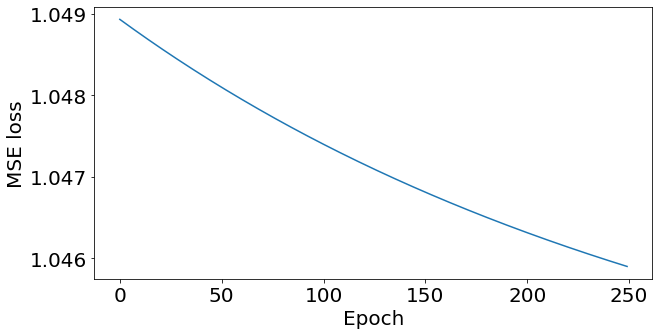

In [8]:
# Plot losses
_, ax = plt.subplots(figsize=(10,5))
ax.plot(losses)
ax.set_ylabel('MSE loss'); ax.set_xlabel('Epoch');

Note that this implementation is not ideal, as it's:

- Non modular (hard to switch components)
- Hard to extend (e.g. to add layers)
- Error prone (hard-coded manual calculations)

But it works!
- In HW2, you'll implement a from scratch MLP that addresses these concerns.
- And now, we'll see how to address these issues using PyTorch's API.

## Part 2: N-Layer MLP using PyTorch

Let's create all our usual components:
- Dataset
- Model
- Loss function
- Optimizer

But this time we'll create a modular implementation where each of these components is separate and can be changed independently of the others.

### Dataset

As in the previous tutorial we'll tackle an image classification task, the MNIST database of handwritten digits.

In [9]:
import torch
import torch.utils.data
import torchvision
import torchvision.transforms

root_dir = os.path.expanduser('~/.pytorch-datasets/')

In [10]:
tf_ds = torchvision.transforms.ToTensor()

batch_size = 512
train_size = batch_size * 10
test_size = batch_size * 2

# Datasets and loaders
ds_train = torchvision.datasets.MNIST(root=root_dir, download=True, train=True, transform=tf_ds)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size,
                                       sampler=torch.utils.data.SubsetRandomSampler(range(0,train_size)))
ds_test =  torchvision.datasets.MNIST(root=root_dir, download=True, train=False, transform=tf_ds)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size,
                                       sampler=torch.utils.data.SubsetRandomSampler(range(0,test_size)))

x0, y0 = ds_train[0]
n_features = torch.numel(x0)
n_classes = 10

print(f'x0: {x0.shape}, y0: {y0}')

x0: torch.Size([1, 28, 28]), y0: 5


In [14]:
import sys
sys.path.append('.')
import plot_utils as plot_utils
# Show first few samples
print(f'x0: {x0.shape}, y0: {y0}')
plot_utils.dataset_first_n(ds_train, 10, cmap='gray', show_classes=True);

ModuleNotFoundError: No module named 'plot_utils'

### Model Implementation

- The `torch.nn` module contains building blocks such as neural network layers,
  loss functions, activations and more.
- In this section, we'll see various parts of the `torch.nn` API.
- We'll use `nn.Linear` which implements a single MLP layer.
- We'll implement our model as a subclass of `nn.Module`, which means:
    - Any tensors we set as properties will be registered as model parameters.
    - We can nest `nn.Modules` and get all model parameters from the top-level `nn.Module`.
    - Can be used as a function if we implement the `forward()` method.

To understand `nn.Module`, lets look at a very basic one: the **fully-connected** layer.

In [16]:
import torch.nn as nn

fc = nn.Linear(in_features=3, out_features=5, bias=True)

# Input tensor with 10 samples of 3 features
t = torch.randn(1, 3)

# Forward pass, notice that grad_fn exists
fc(t)

tensor([[0.3923, 0.7557, 0.7745, 0.0300, 0.7477]], grad_fn=<AddmmBackward>)

`nn.Modules` have registered **parameters**, which are tensors which `require_grad`.

In [17]:
# Note parameter shapes
for i, param in enumerate(fc.parameters()):
    print(f"Parameter #{i} of shape {param.shape}:\n{param.data}\n")

Parameter #0 of shape torch.Size([5, 3]):
tensor([[ 0.4414,  0.4792, -0.1353],
        [ 0.5304, -0.1265,  0.1165],
        [-0.2811,  0.3391,  0.5090],
        [-0.4236,  0.5018,  0.1081],
        [ 0.4266,  0.0782,  0.2784]])

Parameter #1 of shape torch.Size([5]):
tensor([-0.0815,  0.4451,  0.0853, -0.2695,  0.1472])



We can create custom `nn.Module`s with arbitrary logic. 

Let's recreate a fully-connected layer ourselves:

In [24]:
class MyFullyConnectedLayer(nn.Module):
    
    def __init__(self, in_features, out_features):
        super().__init__() # don't forget this!
        
        # nn.Parameter just marks W,b for inclusion in list of parameters
        self.W = nn.Parameter(torch.randn(out_features, in_features, requires_grad=False))
        self.b = nn.Parameter(torch.randn(out_features, requires_grad=True))
                
    def forward(self, x):
        # x assumed to be (N, in_features)
        z = torch.matmul(x, self.W.transpose(0, 1)) + self.b
        
        # Our custom FC layer multiplies all outputs by 3 for no good reason
        return 3 * z

In [25]:
myfc = MyFullyConnectedLayer(in_features=3, out_features=5)

In [21]:
myfc(t)

tensor([[-2.0717,  3.1339,  4.3401,  4.5292,  0.9648]], grad_fn=<MulBackward0>)

In [22]:
list(myfc.parameters())

[Parameter containing:
 tensor([[-1.6898, -0.9890,  0.9580],
         [ 1.3221,  0.8172, -0.7658],
         [-0.7506,  1.3525,  0.6863],
         [-0.3278,  0.7950,  0.2815],
         [ 0.0562,  0.5227, -0.2384]], requires_grad=True),
 Parameter containing:
 tensor([-0.0499,  0.5263, -0.0085,  0.7291,  0.1331], requires_grad=True)]

Quick visualization of our custom module's **computation graph**:

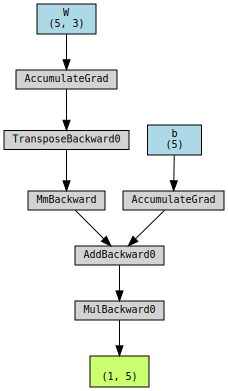

In [26]:
import torchviz
torchviz.make_dot(myfc(t), params=dict(W=myfc.W, b=myfc.b))

Now that we know about `nn.Module`s, lets create an fairly-general MLP for multiclass classification.

In [27]:
class MLP(torch.nn.Module):
    NLS = {'relu': torch.nn.ReLU, 'tanh': nn.Tanh, 'sigmoid': nn.Sigmoid, 'softmax': nn.Softmax, 'logsoftmax': nn.LogSoftmax}

    def __init__(self, D_in: int, hidden_dims: Sequence[int], D_out: int, nonlin='relu'):
        super().__init__()
        
        all_dims = [D_in, *hidden_dims, D_out]
        non_linearity = MLP.NLS[nonlin]
        layers = []
        
        for in_dim, out_dim in zip(all_dims[:-1], all_dims[1:]):
            layers += [
                nn.Linear(in_dim, out_dim, bias=True),
                non_linearity()
            ]
        
        # Sequential is a container for layers
        self.fc_layers = nn.Sequential(*layers[:-1])
        
        # Output non-linearity
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], -1))
        z = self.fc_layers(x)
        y_pred = self.log_softmax(z)
        # Output is always log-probability
        return y_pred

In [28]:
# Create an instance of the model: 5-layer MLP
mlp5 = MLP(D_in=n_features, hidden_dims=[32, 64, 128, 64], D_out=n_classes, nonlin='tanh')

print(mlp5)

MLP(
  (fc_layers): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
  (log_softmax): LogSoftmax(dim=1)
)


In [29]:
# Parameter tensors in nested nn.Modules are automatically discovered.
print(f'number of parameter tensors: {len(list(mlp5.parameters()))}')

number of parameter tensors: 10


In [30]:
print(f'number of parameters: {np.sum([torch.numel(p) for p in mlp5.parameters()])}')

number of parameters: 44458


In [31]:
# Test a forward pass
y_hat0 = mlp5(x0)

print(f'{x0.shape=}\n')
print(f'{y_hat0.shape=}\n')
print(f'{y_hat0=}')

x0.shape=torch.Size([1, 28, 28])

y_hat0.shape=torch.Size([1, 10])

y_hat0=tensor([[-2.3386, -2.3962, -2.2378, -2.1579, -2.4067, -2.2850, -2.3669, -2.1454,
         -2.3853, -2.3490]], grad_fn=<LogSoftmaxBackward>)


Quick visualization of our full MLP's **computation graph**:

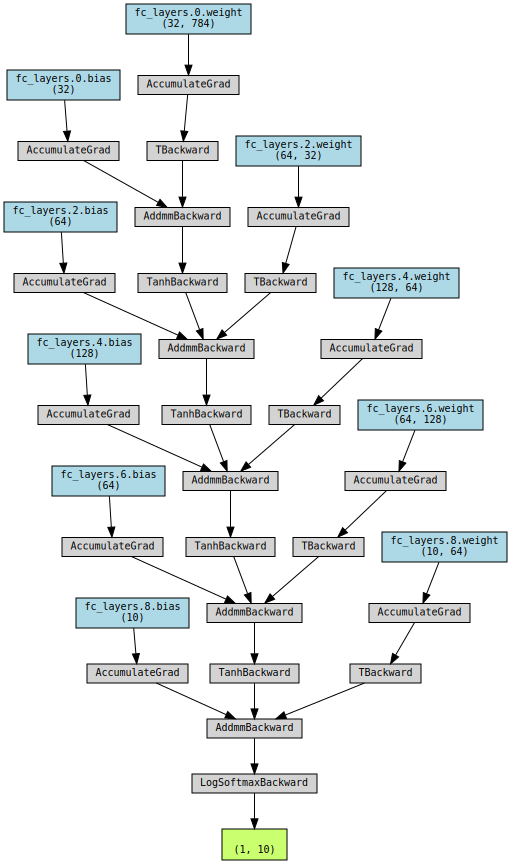

In [32]:
torchviz.make_dot(mlp5(x0), params=dict(mlp5.named_parameters()))

### Loss and Optimizer

For the loss function, we'll use PyTorch's built in negative log-likelihood loss since our model outputs probabilities.

In [33]:
import torch.optim

# Loss:
# Note: NLLLoss assumes *log*-probabilities (given by our LogSoftmax layer)
loss_fn = nn.NLLLoss()

# Fake ground-truth labels
# Notice that we don't need to 1-hot encode them!
yt = torch.randint(low=0, high=n_classes, size=(y_hat0.shape[0],))

# Try out the loss
loss_fn(y_hat0, yt) 

tensor(2.1579, grad_fn=<NllLossBackward>)

Note that `nn.NLLLoss(y_hat, y)` assumes that $\hat{\vec{y}}^{(i)}=\log\left(\mathrm{softmax}\left(\vec{z}^{(i)}\right)\right)$, where $\vec{z}^{(i)}\in\set{R}^C$ contains the raw scores for input $\vec{x}^{(i)}$, and therefore it simply computes:

$$
L_{\mathrm{NLL}}
= \sum_{i=1}^{N} -\left[\hat{\vec{y}}^{(i)}\right]_{y^{(i)}}
= \sum_{i=1}^{N} -\left[ \log\left(\mathrm{softmax}\left(\vec{z}^{(i)}\right)\right) \right]_{y^{(i)}}
$$

where $y^{(i)}\in\left\{0,1,\dots,C-1\right\}$ is the ground-truth class label of for sample $i$.

As for the optimization scheme, we'll use a built in SGD optimizer from the `torch.optim` module.
We will see that the semantics of using it are similar to the simple optimizer we implemented last tutorial.

We won't need to calculate the loss gradient this time, as we'll use `autograd` for automatic differentiation.

In [34]:
torch.manual_seed(42)

# Model for training
model = MLP(D_in=n_features, hidden_dims=[32, 32, 32], D_out=n_classes, nonlin='relu')

# Optimizer over our model's parameters
optimizer = torch.optim.SGD(params=model.parameters(), lr=5e-2, weight_decay=0.01, momentum=0.9)

### Training loop

This time we'll train over lazy-loaded batches from our data loader.

Notice that except from our model's `__init__()` and `__forward()__`, we're using PyTorch facilities for the entire training implementation.

In [35]:
num_epochs = 10
for epoch_idx in range(num_epochs):
    total_loss = 0
    
    for batch_idx, (X, y) in enumerate(dl_train):
        # Forward pass
        y_pred = model(X)

        # Compute loss
        loss = loss_fn(y_pred, y)
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad() # Zero gradients of all parameters
        loss.backward()       # Run backprop algorithms to calculate gradients
        
        # Optimization step
        optimizer.step()      # Use gradients to update model parameters
        
    print(f'Epoch #{epoch_idx+1}: Avg. loss={total_loss/len(dl_train)}')

Epoch #1: Avg. loss=2.305134344100952
Epoch #2: Avg. loss=2.2864507913589476
Epoch #3: Avg. loss=2.256749725341797
Epoch #4: Avg. loss=2.1769882917404173
Epoch #5: Avg. loss=1.9311089515686035
Epoch #6: Avg. loss=1.4161056518554687
Epoch #7: Avg. loss=0.9191414058208466
Epoch #8: Avg. loss=0.6763370990753174
Epoch #9: Avg. loss=0.5613922148942947
Epoch #10: Avg. loss=0.5014606863260269


Using the basic PyTorch building blocks we have arrived at a much more robust implementation:
- Easy to change architecture: layers and activation functions
- Easy to change loss
- Easy to change optimization method
- No need for manual gradient derivations

#### Thanks!

**Credits**

This tutorial was written by [Aviv A. Rosenberg](https://avivr.net).<br>
To re-use, please provide attribution and link to the original.

Some images in this tutorial were taken and/or adapted from the following sources:

- MartinThoma [CC0], via Wikimedia Commons https://commons.wikimedia.org/wiki/File:Perceptron-unit.svg
- Pattern Recognition and Machine Learning, C. M. Bishop, Springer, 2006
- Sebastian Raschka https://sebastianraschka.com/Articles/2015_singlelayer_neurons.html
- Favio Vázquez https://towardsdatascience.com/a-conversation-about-deep-learning-9a915983107
- Fundamentals of Deep Learning, Nikhil Buduma, Oreilly 2017